In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('../datasets/d5.csv')

In [3]:
df

,Date,Energy Consumption
0,2020-01-01,305.311409
1,2020-01-02,299.374329
2,2020-01-03,307.646359
3,2020-01-04,316.811967
4,2020-01-05,299.651923
...,...,...
1455,2023-12-26,380.398916
1456,2023-12-27,405.951747
1457,2023-12-28,402.642110
1458,2023-12-29,412.140555


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Normalize the 'Energy Consumption' data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['Energy Consumption'].values.reshape(-1, 1))

lookback = 30  # Number of previous days to consider for prediction
X, y = [], []

for i in range(len(data) - lookback):
    X.append(data[i:i + lookback])
    y.append(data[i + lookback])

X, y = np.array(X), np.array(y)

# Convert to PyTorch tensors
X = torch.FloatTensor(X).view(-1, lookback, 1)  # Shape: (samples, time_steps, features)
y = torch.FloatTensor(y)  # Shape: (samples, 1)

NameError: name 'MinMaxScaler' is not defined

In [16]:
import torch
import torch.nn as nn

class EnergyLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=1):
        super(EnergyLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(x.device)

        # LSTM output
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the last timestep's output to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

In [17]:
# Model parameters
input_size = 1
hidden_layer_size = 50
output_size = 1
num_layers = 1

model = EnergyLSTM(input_size, hidden_layer_size, output_size, num_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
num_epochs = 500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train.view(-1, 1))
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test.view(-1, 1))
        val_losses.append(val_loss.item())

    # Display the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

Epoch [10/500], Train Loss: 0.0058, Validation Loss: 0.0061
Epoch [20/500], Train Loss: 0.0054, Validation Loss: 0.0056
Epoch [30/500], Train Loss: 0.0052, Validation Loss: 0.0052
Epoch [40/500], Train Loss: 0.0050, Validation Loss: 0.0050
Epoch [50/500], Train Loss: 0.0048, Validation Loss: 0.0047
Epoch [60/500], Train Loss: 0.0047, Validation Loss: 0.0045
Epoch [70/500], Train Loss: 0.0046, Validation Loss: 0.0044
Epoch [80/500], Train Loss: 0.0045, Validation Loss: 0.0043
Epoch [90/500], Train Loss: 0.0045, Validation Loss: 0.0042
Epoch [100/500], Train Loss: 0.0045, Validation Loss: 0.0042
Epoch [110/500], Train Loss: 0.0045, Validation Loss: 0.0041
Epoch [120/500], Train Loss: 0.0045, Validation Loss: 0.0041
Epoch [130/500], Train Loss: 0.0045, Validation Loss: 0.0041
Epoch [140/500], Train Loss: 0.0045, Validation Loss: 0.0041
Epoch [150/500], Train Loss: 0.0045, Validation Loss: 0.0041
Epoch [160/500], Train Loss: 0.0045, Validation Loss: 0.0041
Epoch [170/500], Train Loss: 0.00

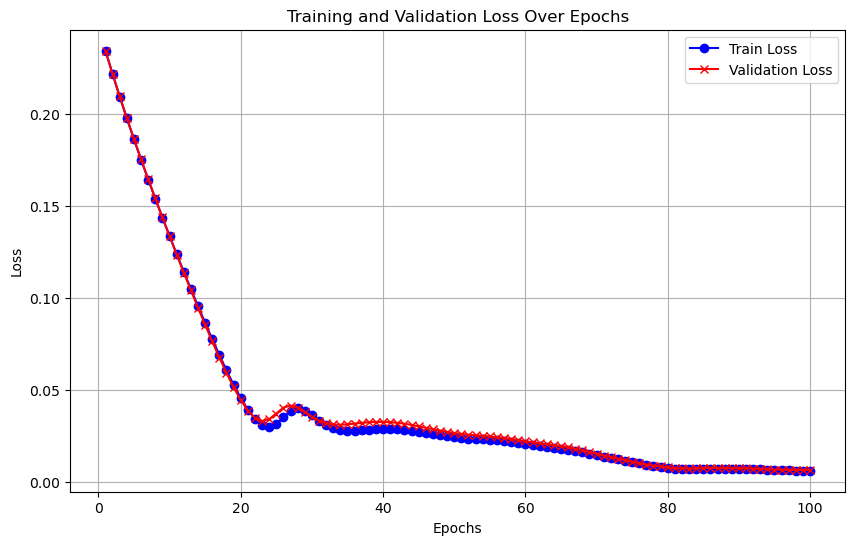

In [21]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_losses have been recorded during training
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()